# Introduction
This notebook aims to help the reader to walk through the YoloV1 code for MNIST localization. It will not explain all the code in detail but will focus on the most important parts.

I won't go into YoloV1 details so I give you some articles that help me to understand the all process :
* YoloV1 [paper](https://arxiv.org/pdf/1506.02640.pdf)
* GitHub [repo](https://github.com/zzzheng/pytorch-yolo-v1) of @zzzheng
* Medium [article](https://medium.com/mlearning-ai/object-detection-explained-yolo-v1-fb4bcd3d87a1)
* @Hackernoon [article](https://hackernoon.com/understanding-yolo-f5a74bbc7967)
* Excellent [web page](https://pjreddie.com/darknet/yolo/) about Yolo, Darknet models, and other stuffs from @Joseph Chet Redmon

### Terminology :
* B : number of bounding boxes generated by the model (here 1)
* C : number of classes (here 10)
* S : number of grid cells in one direction (here 6)
* \*r or \*r_img : indicate a value *relatives to the image size*
* \*cr_img : indicate a **center** value *relatives to the image size*
* \*r_cell : indicate a value *relatives to a cell*
* \*cr_cell : indicate a **center** value *relatives to a cell*

# Dataset
I use the MNIST dataset from http://yann.lecun.com/exdb/mnist/ available in the `torchvision` framework. This dataset is composed of 60k training and 10k validation 28x28 greyscale images. 

To create my dataset I proceed through those steps (see [MNIST_dataset.py](https://github.com/ThOpaque/Food_Recognition/blob/main/WarmingUp_with_MNIST/MNIST_dataset.py) for the full code) :
* Randomly paste the 28x28 digits into a 75x75 black background
* Retrieve the xmin, ymin (top left coordinates), the width and height
* Encode those coordinates *relative to the cell* for xmin, ymin and *relative to the image* for the width and height
* Include those coordinates in a (N,S,S,B+1) tensor
* One-hot encoded the digit labels and include them in a (N,S,S,C) tensor

At the end, a SxS grid is obtained for each image. See below, for `S=6` and the digit `0` : its bounding box size is 28x28 (0.3733x0.3733 relatively to the image) and its center is in the cell `(2,1)`, preciselly, at the coordinates `(0.60, 0.32)` *respectively to this cell*.  

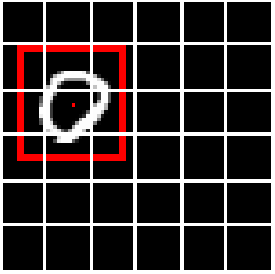

#####################################################
```python
def _encode(self, box, label):    
    ...
    ### Object grid location
    i = (xcr_img / self.cell_size).ceil() - 1.0
    j = (ycr_img / self.cell_size).ceil() - 1.0
    i, j = int(i), int(j)

    ### x & y of the cell left-top corner
    x0 = i * self.cell_size
    y0 = j * self.cell_size
    
    ### x & y of the box on the cell, normalized from 0.0 to 1.0.
    xcr_cell = (xcr - x0) / self.cell_size
    ycr_cell = (ycr - y0) / self.cell_size

    ### 4 coords + 1 conf + 10 classes
    one_hot_label = F.one_hot(torch.as_tensor(label, dtype=torch.int64), self.C)

    box_target = torch.zeros(self.S, self.S, self.B+4)
    box_target[j, i, :5] = torch.Tensor([xcr_cell, ycr_cell, wr, hr, 1.])

    return box_target, one_hot_label
```
#####################################################

# Darknet-like model
I first started to create the same model from the Yolo paper. 

[IMG YOLO ARCHITECTURE]

But of course, to achieve my purpuse on MNIST, I do not need a such complex model. So, I created a [Darknet-like](https://github.com/ThOpaque/Food_Recognition/blob/main/WarmingUp_with_MNIST/Darknet_like.py) one, by keeping the same global topology :
- Using CNN Blocks which contains a convolutional layer, a batch normalization layer and a LeakyReLU activation
- CNN Blocks are followed by a MaxPool layer except the last ones before fully connected layers
- LeakyReLU activation between the two fully connected layers
- The last fully connected layer outputs a tensor of size (N, S, S, C+B+4+1)

To make the code cleaner, I choose to dissociate the "classification output" (used to classify the digits) and the "regression output" (used to predict the bounding box coordinates) in the forward. 

### Darknet-like model
```python
class YoloMNIST(torch.nn.Module):
    def __init__(self, sizeHW, S, C, B):
        ...
        self.seq = torch.nn.Sequential()        
        self.seq.add_module(f"conv_1", CNNBlock(1, 32, stride=2, kernel_size=7, padding=2))
        self.seq.add_module(f"maxpool_1", torch.nn.MaxPool2d(2))
        self.seq.add_module(f"conv_2", CNNBlock(32, 128, stride=1, kernel_size=3, padding=0))
        self.seq.add_module(f"maxpool_2", torch.nn.MaxPool2d(2))
        self.seq.add_module(f"conv_3", CNNBlock(128, 64, stride=1, kernel_size=1, padding=0))
        self.seq.add_module(f"conv_4", CNNBlock(64, 128, stride=1, kernel_size=3, padding=0))
        self.seq.add_module(f"conv_5", CNNBlock(128, 128, stride=1, kernel_size=3, padding=1))
        self.fcs = self._create_fcs()

    def _create_fcs(self):
        output = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(128 * self.S * self.S, 4096),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(4096, self.S * self.S * (self.C + self.B*5)))
        return output

    def forward(self, input:torch.Tensor)->tuple:
        x = self.seq(input)
        x = self.fcs(x)
        x = x.view(x.size(0), self.S, self.S, self.B * 5 + self.C)
        box_coord = x[:,:,:,0:5]
        classifier = x[:,:,:,5:]
        return box_coord, classifier
```


# Yolo Loss
From the Yolo paper, I recall the global formula of the Yolo loss. Again, I recommand you to look at the references I listed above.
 